# <center>Channel Attribution</center>
<center>Dwipam Katariya, IU Data Science</center>

## Initial Analysis

 - Data available from Jul 28th to Dec 27th
 - Maximum 26 Total attributes for Advertisements
 - Total Unique Keywords : 269
 - Total number of channels : 9 (Display, search, email, affiliate, social-inferred, set, social, affiliate-inferred, email-inferred )
 - Total Converted users 0.77%
 - 318 users lack advertisement information
 - 82% Users are converted through unknown channel. either for them data was not recorded or they were not exposed to Advertisements.
 - 33 users were exposed to advertisement out of which 8 were converted before exposed to advertisement. 
 - There are no users exposed to advertisement first and then later converted after long period of time.


## Class Distribution :

<img src="Distribution.png" width="150">

Just 0.13% Converted users left after filtering out users that did not have channel information

## % Conversion to Total Conversion by Time

<img src="cnv.png" width="1000">

Around September to Nov there were high conversions of the user. Hence Month and week number might be a good variable for user to convert

## Channel used independent of previous channels per events

For Non Converted users Display channel was used mostly, followed by search. For Converted user Search channel followed by SEM and then Display. There can be series of events responsible for a user conversion, however here we are considering independent contribution of channels for both events. 

<img src="con.png" width="500">

## Actions contribution independently per events

<img src="act.png" width="200">

Clicked actions were made by the user more than impression when user converted. While Impression actions were made more than Clicked when users did not convert.

## Page URL Host per event

<img src="pg2.png" width = 700>

Converted users mostly visit www.atkins.com and webistes related to Atkins product. While non converted users are from third party source. Here I have only displayed top contributors page url host as displaying others would be mess. We can also consider page url host as a factor of conversion.

## Word Cloud for Reference URL Host

<img src="ReqUrlDevice.png" width = 1000>

There seems to be difference in Reference URL host distribition. Large the size, larger is the percentage of occurence for the url in the given class. Bing.com has the highest percentage of occurence in Converted Computer type, while ypc.googlesyndication and other other third party url with has larger occurence in Non Converted with Computer as device type. As www.google.com is most common, I filtered it to check for other URLs.

## Keywords word Cloud

    It would be interseting to see how the keywords are distributed across devices. As Converted users just 2-3 keywords, I just visualized how keywords might differ across device types.
<img src="wr.png" width=1000>

# Model Building

## 1. User-Level model building:

User level modeling is modeling where you capture all the information from the data for a given user.
To check how influential is each channel for driving the attribution, I converted data to per user format. Where every row is an user and it has following variables:
    - Converted : (Yes/No) 
    - First Channel : First Channel used to advertised
    - Last Channel : Last Channel used to advertised
    - Last Date : Timestamp for last advertisement recorded
    - First Date : Timestamp for First advertisement recorded
    - NCA : Number of advertisements exposed using Affiliate channel
    - NCD : Number of advertisements exposed using Display channel
    - NCS : Number of advertisements exposed using Search channel
    - NCE : Number of advertisements exposed using Email channel
    - NCSOI : Number of advertisements exposed using social-inferred channel
    - NCSEM : Number of advertisements exposed using SEM channel
    - NCSO : Number of advertisements exposed using Social channel
    - NCAFI : Nuumber of advertisements exposed using Affiliate inferred channel
    - NCEMI : Number of advertisements exposed using Email inferred channel
    - Device Types : Total Number of device types used by a give used for the lifetime
    - Event Timestamp : Time of conversion if user has converted (i.e. conversion_id is not empty). Otherwise it is time of when this entry is recorded.

In [112]:
data.head()

,Converted,First_channel,First_date,Last_channel,Last_date,NCA,NCAFI,NCD,NCE,NCEMI,NCS,NCSEM,NCSO,NCSOI,NTC,NTV,Userid,device_types,event_timestamp
0,0,display,2016-09-12 17:42:58,display,2016-09-12 17:42:58,0,0,1,0,0,0,0,0,0,0,1,000000b7-6230-4900-a27f-c92e0ba6fc4c,1,2016-09-12 17:42:58
1,0,search,2016-10-10 15:44:53,search,2016-10-10 15:44:53,0,0,0,0,0,1,0,0,0,1,0,000001b9-0cea-4ebf-80a8-efe22c902a64,1,2016-10-10 15:44:53
2,0,display,2016-08-24 05:27:50,display,2016-08-24 05:27:50,0,0,1,0,0,0,0,0,0,0,1,00000621-8230-4551-82ba-45f08de06094,1,2016-08-24 05:27:50
3,0,display,2016-09-23 16:01:14,display,2016-09-23 16:01:14,0,0,1,0,0,0,0,0,0,0,1,000010ee-9832-47f0-a9fd-3883fce71d2e,1,2016-09-23 16:01:14
4,0,display,2016-08-03 04:18:52,display,2016-08-03 04:18:52,0,0,1,0,0,0,0,0,0,0,1,00002833-6883-40df-ad54-90e016b9badb,1,2016-08-03 04:18:52


### Some pre-processing
    
    To process the data into tabular format there is another python script that outputs User level Tabular data. 
    Another R script utilizes the data to generate Filtered data. However for Timestamps, we need to convert it to   Month, week and hour columns to be utilized in Machine Learning model.

In [100]:
import pandas as pd
import graphlab as gl
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from h2o.estimators.random_forest import H2ORandomForestEstimator 
import h2o

In [111]:
data = pd.read_csv('Filtered_data.csv',infer_datetime_format=True)
converted = data['Converted']

In [102]:
data['First_date_month'] = pd.DatetimeIndex(data['First_date']).month
data['First_date_week'] = pd.DatetimeIndex(data['First_date']).week
data['First_hour'] = pd.DatetimeIndex(data['First_date']).hour
data['Last_date_month'] = pd.DatetimeIndex(data['Last_date']).month
data['Last_date_week'] = pd.DatetimeIndex(data['Last_date']).week
data['Last_hour'] = pd.DatetimeIndex(data['Last_date']).hour
data['event_month'] = pd.DatetimeIndex(data['event_timestamp']).month
data['event_week'] = pd.DatetimeIndex(data['event_timestamp']).week
data['event_hour'] = pd.DatetimeIndex(data['event_timestamp']).hour
del data['First_date']; del data['Last_date'];del data['event_timestamp']


In [103]:
userId = data['Userid']
del data['Userid']

### Check for correlations

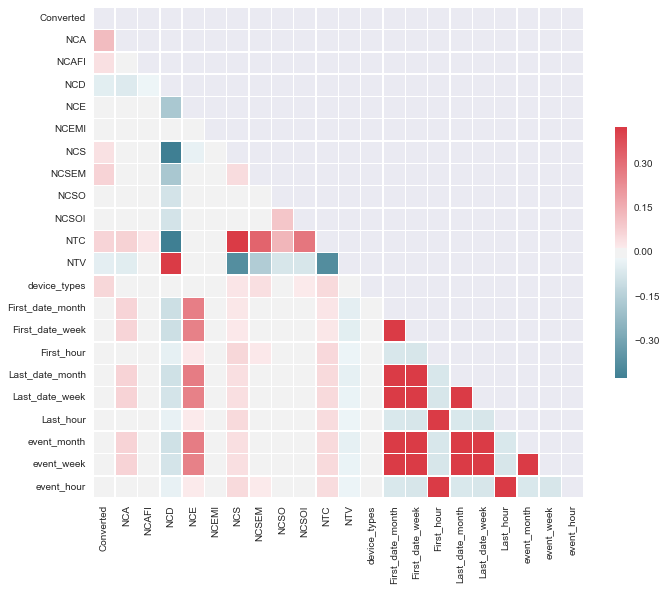

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
def plot_corr(data):
    corr = data.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True,linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plot_corr(data)

"Correlation is not causation", There seems to be some highly correlated. Therefore, buuilding our base model, let's remove these correlated features. Search and display are negatively correlated and similarly for Click and View. But we will keep these features are they are correlated. Objective is study the effects of channels, hence we won't do dimensionality reduction techniques.

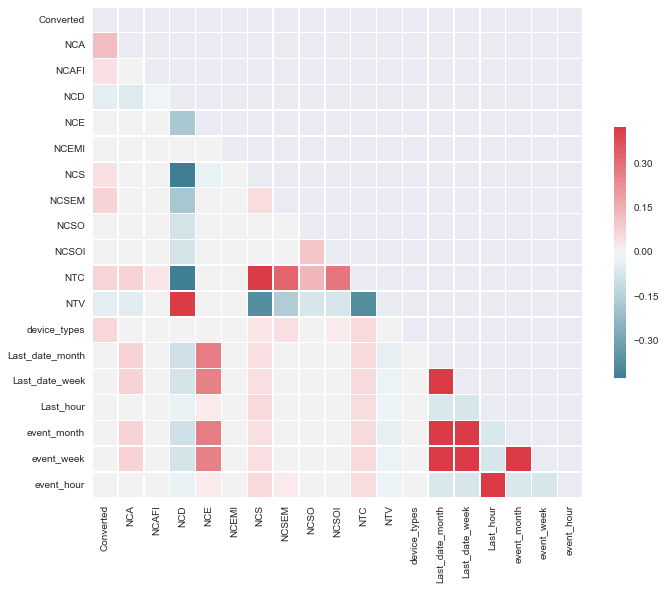

In [105]:
del data['First_date_month'];del data['First_date_week'];del data['First_hour']
plot_corr(data)

### Split in Train and Test data

As there is skewed distribution of classes, random stratified sampling to split the data into train and test seems be the best choice.

In [106]:
from sklearn.cross_validation import train_test_split
X = data
Y = data['Converted']
X = X.drop('Converted',axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)
Y_test.value_counts()

0    9917
1      13
Name: Converted, dtype: int64

In [107]:
trainData = pd.concat([X_train,pd.DataFrame({'Converted':Y_train})],axis=1)
testData = pd.concat([X_test,pd.DataFrame({'Converted':Y_test})],axis=1)
trainData['Converted'] = (trainData['Converted']).apply(lambda x:int(x))

# UnderSampling and Class weighting.

To handle imbalance datasets there are following ways:
    - Undersampling
    - Oversampling
    - Class weighting
    - Anomaly detection
    - Cost sensitive learning
As our data is sparse and redundant data, starting with Undersampling and class weighting seems to be reasonal choice. To check to see if data is log linearly seperable as, the base model logistic regression can be used. Due to colliniarity and need to perform feature selection to see what drives the classification, I used Lasso regression.

In [108]:
trainData = data
trainData = trainData[trainData['Converted']==0].sample(200).append(trainData[trainData['Converted']==1])

In [109]:
weights = {0:((trainData[trainData['Converted']==1].shape[0])*1.0/(trainData.shape[0])),1:((trainData[trainData['Converted']==0].shape[0])*1.0/trainData.shape[0])}
import graphlab as gl
def logistic(trainData,testData):
    modelGL = gl.logistic_classifier.create(gl.SFrame(trainData),target = 'Converted',max_iterations = 100,verbose=False,class_weights = weights,l1_penalty=0.5)
    print modelGL.evaluate(gl.SFrame(testData))
    print modelGL['coefficients'] 
logistic(trainData,testData)

{'f1_score': 0.020984665052461667, 'auc': 0.9591571582597124, 'recall': 1.0, 'precision': 0.010603588907014683, 'log_loss': 0.342114612915222, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+-----+----+------+
| threshold |      fpr       | tpr | p  |  n   |
+-----------+----------------+-----+----+------+
|    0.0    |      1.0       | 1.0 | 13 | 9917 |
|   1e-05   | 0.999899163053 | 1.0 | 13 | 9917 |
|   2e-05   | 0.999899163053 | 1.0 | 13 | 9917 |
|   3e-05   | 0.999899163053 | 1.0 | 13 | 9917 |
|   4e-05   | 0.999798326107 | 1.0 | 13 | 9917 |
|   5e-05   | 0.999798326107 | 1.0 | 13 | 9917 |
|   6e-05   | 0.999798326107 | 1.0 | 13 | 9917 |
|   7e-05   | 0.999596652213 | 1.0 | 13 | 9917 |
|   8e-05   | 0.999596652213 | 1.0 | 13 | 9917 |
|   9e-05   | 0.999596652213 | 1.0 | 13 | 9917 |
+-----------+----------------+-----+----+------+
[100001 rows x 5 columns]
Note: Only the head of the SFrame is printed.
You

We can see that First Channel and Last Channel influences a lot with search in Last Channel, followed by sem . However due to colliniearity in data this interpretaion can be falsified, as all the coefficients are not shrunk to zero. We check with random-Forest to check the important variables. Also though we have good AUC, F-1 score is low wih low precision. Affiliate-inferred and email-inferred are cannot be used for prediction as they have 0 coefficents.

In [114]:
X_train = h2o.H2OFrame(trainData); X_test = h2o.H2OFrame(data);
X_train['Converted'] = (X_train['Converted']).asfactor();X_test['Converted'] = (X_test['Converted']).asfactor();
def random_forest(X_train, X_test, hyperParam):
    model = h2o.estimators.H2OGradientBoostingEstimator(model_id = 'base_rf',ntrees = hyperParam['ntree'], max_depth = hyperParam['max_depth'],balance_classes =False,validation_frame=X_test,nfolds=5) 
    model.train(y='Converted',training_frame = X_train)
    print model.model_performance(X_test)
    print model
hyperParam = {'ntree':100,'max_depth':5}
random_forest(X_train,X_test,hyperParam)

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████████████████████████| 100%

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.101559022856
RMSE: 0.31868326416
LogLoss: 0.302864729218
Mean Per-Class Error: 0.102740402301
AUC: 0.911921725325
Gini: 0.82384345065
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.977458025085: 


,0,1,Error,Rate
0,48785.0,797.0,0.0161,(797.0/49582.0)
1,44.0,23.0,0.6567,(44.0/67.0)
Total,48829.0,820.0,0.0169,(841.0/49649.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.9774580,0.0518602,4.0
max f2,0.9157233,0.1072664,21.0
max f0point5,0.9774580,0.0343591,4.0
max accuracy,0.9850415,0.9986102,0.0
max precision,0.9774580,0.0280488,4.0
max recall,0.0026568,1.0,53.0
max specificity,0.9850415,0.9999597,0.0
max absolute_mcc,0.9157233,0.1060711,21.0
max min_per_class_accuracy,0.7417945,0.8696099,40.0
max mean_per_class_accuracy,0.6715323,0.8972596,44.0


Gains/Lift Table: Avg response rate:  0.13 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0139378,0.9822299,11.7793762,11.7793762,0.0158960,0.0158960,0.1641791,0.1641791,1077.9376240,1077.9376240
,2,0.0204838,0.9654821,36.4814696,19.6733589,0.0492308,0.0265487,0.2388060,0.4029851,3548.1469575,1867.3358869
,3,0.1136579,0.8728705,4.1648889,6.9598763,0.0056204,0.0093922,0.3880597,0.7910448,316.4888915,595.9876323
,4,1.0,0.0026568,0.2357501,1.0,0.0003181,0.0013495,0.2089552,1.0,-76.4249923,0.0




Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  base_rf
Model Summary: 


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,100.0,100.0,19774.0,5.0,5.0,5.0,6.0,16.0,10.73




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.011647514477
RMSE: 0.107923651148
LogLoss: 0.0595175136432
Mean Per-Class Error: 0.00746268656716
AUC: 0.999589552239
Gini: 0.999179104478
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.701225688027: 


,0,1,Error,Rate
0,200.0,0.0,0.0,(0.0/200.0)
1,1.0,66.0,0.0149,(1.0/67.0)
Total,201.0,66.0,0.0037,(1.0/267.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.7012257,0.9924812,64.0
max f2,0.7012257,0.9880240,64.0
max f0point5,0.7012257,0.9969789,64.0
max accuracy,0.7012257,0.9962547,64.0
max precision,0.9985092,1.0,0.0
max recall,0.3725349,1.0,70.0
max specificity,0.9985092,1.0,0.0
max absolute_mcc,0.7012257,0.9900373,64.0
max min_per_class_accuracy,0.7012257,0.9850746,64.0
max mean_per_class_accuracy,0.7012257,0.9925373,64.0


Gains/Lift Table: Avg response rate: 25.09 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0112360,0.9936639,3.9850746,3.9850746,1.0,1.0,0.0447761,0.0447761,298.5074627,298.5074627
,2,0.0224719,0.9828649,3.9850746,3.9850746,1.0,1.0,0.0447761,0.0895522,298.5074627,298.5074627
,3,0.0299625,0.9789741,3.9850746,3.9850746,1.0,1.0,0.0298507,0.1194030,298.5074627,298.5074627
,4,0.0449438,0.9770089,3.9850746,3.9850746,1.0,1.0,0.0597015,0.1791045,298.5074627,298.5074627
,5,0.0524345,0.9763450,3.9850746,3.9850746,1.0,1.0,0.0298507,0.2089552,298.5074627,298.5074627
,6,0.1011236,0.9528600,3.9850746,3.9850746,1.0,1.0,0.1940299,0.4029851,298.5074627,298.5074627
,7,0.1498127,0.9145075,3.9850746,3.9850746,1.0,1.0,0.1940299,0.5970149,298.5074627,298.5074627
,8,0.2022472,0.8247008,3.9850746,3.9850746,1.0,1.0,0.2089552,0.8059701,298.5074627,298.5074627
,9,0.2996255,0.1749789,1.9925373,3.3375,0.5,0.8375,0.1940299,1.0,99.2537313,233.75
,10,0.4082397,0.0208628,0.0,2.4495413,0.0,0.6146789,0.0,1.0,-100.0,144.9541284




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.107717402187
RMSE: 0.328203293991
LogLoss: 0.4288854799
Mean Per-Class Error: 0.127313432836
AUC: 0.887313432836
Gini: 0.774626865672
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32271810426: 


,0,1,Error,Rate
0,178.0,22.0,0.11,(22.0/200.0)
1,10.0,57.0,0.1493,(10.0/67.0)
Total,188.0,79.0,0.1199,(32.0/267.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3227181,0.7808219,78.0
max f2,0.0344626,0.8469945,95.0
max f0point5,0.5867253,0.7522124,67.0
max accuracy,0.3828527,0.8801498,74.0
max precision,0.9990511,1.0,0.0
max recall,0.0002749,1.0,244.0
max specificity,0.9990511,1.0,0.0
max absolute_mcc,0.3227181,0.7036058,78.0
max min_per_class_accuracy,0.1219582,0.8656716,82.0
max mean_per_class_accuracy,0.0344626,0.8726866,95.0


Gains/Lift Table: Avg response rate: 25.09 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0112360,0.9939265,3.9850746,3.9850746,1.0,1.0,0.0447761,0.0447761,298.5074627,298.5074627
,2,0.0224719,0.9850229,2.6567164,3.3208955,0.6666667,0.8333333,0.0298507,0.0746269,165.6716418,232.0895522
,3,0.0299625,0.9805775,3.9850746,3.4869403,1.0,0.875,0.0298507,0.1044776,298.5074627,248.6940299
,4,0.0411985,0.9797247,2.6567164,3.2605156,0.6666667,0.8181818,0.0298507,0.1343284,165.6716418,226.0515604
,5,0.0524345,0.9766807,2.6567164,3.1311301,0.6666667,0.7857143,0.0298507,0.1641791,165.6716418,213.1130064
,6,0.1011236,0.9371848,2.1458094,2.6567164,0.5384615,0.6666667,0.1044776,0.2686567,114.5809414,165.6716418
,7,0.1498127,0.8934245,3.0654420,2.7895522,0.7692308,0.7,0.1492537,0.4179104,206.5442021,178.9552239
,8,0.2022472,0.8033546,2.8464819,2.8043118,0.7142857,0.7037037,0.1492537,0.5671642,184.6481876,180.4311774
,9,0.2996255,0.1951701,2.9121699,2.8393657,0.7307692,0.7125,0.2835821,0.8507463,191.2169920,183.9365672
,10,0.4007491,0.0241595,0.7379768,2.3091087,0.1851852,0.5794393,0.0746269,0.9253731,-26.2023217,130.9108662



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8967487,0.0323543,0.8461539,0.8367347,0.9333333,0.9230769,0.9444444
auc,0.8889983,0.0323040,0.8890978,0.8603604,0.9067103,0.8264300,0.9623932
err,0.1032514,0.0323543,0.1538462,0.1632653,0.0666667,0.0769231,0.0555556
err_count,5.4,1.5231546,8.0,8.0,4.0,4.0,3.0
f0point5,0.7809686,0.0648906,0.6914893,0.6521739,0.8219178,0.877193,0.8620689
f1,0.8228546,0.0417268,0.7647059,0.75,0.8571429,0.8333333,0.9090909
f2,0.8776655,0.0386469,0.8552632,0.8823530,0.8955224,0.7936508,0.9615384
lift_top_group,3.185934,1.1535517,3.7142856,0.0,4.6153846,4.0,3.6
logloss,0.4373676,0.1069903,0.4587249,0.6923267,0.2904653,0.4702686,0.2750526
max_per_class_error,0.1570084,0.0474484,0.1842105,0.2162162,0.0769231,0.2307692,0.0769231


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2017-04-09 01:02:23,1.831 sec,0.0,0.4335519,0.5633615,0.5,1.0,0.7490637
,2017-04-09 01:02:23,1.835 sec,1.0,0.4059176,0.5041148,0.9578358,3.9850746,0.1011236
,2017-04-09 01:02:23,1.837 sec,2.0,0.3817161,0.4576044,0.9649254,3.9850746,0.0973783
,2017-04-09 01:02:23,1.839 sec,3.0,0.3614187,0.4211060,0.9658955,3.9850746,0.0861423
,2017-04-09 01:02:23,1.841 sec,4.0,0.3437331,0.3907432,0.9672761,3.9850746,0.0936330
---,---,---,---,---,---,---,---,---
,2017-04-09 01:02:23,2.412 sec,96.0,0.1128595,0.0630412,0.9995896,3.9850746,0.0037453
,2017-04-09 01:02:23,2.423 sec,97.0,0.1110461,0.0619882,0.9995896,3.9850746,0.0037453
,2017-04-09 01:02:23,2.431 sec,98.0,0.1096418,0.0607041,0.9995896,3.9850746,0.0037453
,2017-04-09 01:02:23,2.439 sec,99.0,0.1094276,0.0604003,0.9995896,3.9850746,0.0037453



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
NTC,127.7860489,1.0,0.5841431
Last_channel,20.5114231,0.1605138,0.0937630
Last_hour,18.1926460,0.1423680,0.0831633
event_hour,13.4278231,0.1050805,0.0613821
event_week,11.7418633,0.0918869,0.0536751
Last_date_week,10.0586615,0.0787149,0.0459807
First_channel,10.0528316,0.0786692,0.0459541
Last_date_month,3.6773741,0.0287776,0.0168102
event_month,2.3501501,0.0183913,0.0107431
NCA,0.6774041,0.0053011,0.0030966


There is overfitting, but still just to check what channels influences Conversion, we can check the important variables. Last_channel, Action Clicked and Data of the week for Last channel seems to be important variables for classification. As our task here is to see the effect of channels driving conversion and classification, I won't tune the parameters ahead for optimizing evaluation metrics.

# Improvements:
    - Perform Neural Network modeling to get better approximations of non-linearity
    - Perform Dimensionality reduction to reduce multicollinearity.
    - Perform unsupervised learning to look if there are id's in the neighborhood of id's of train data.
    - Try different transformations on Volume and bin id's into different categories.
    - Work on tuning parameters of RF and GBM (GBM with Laplace Smoothing, RF with different bags, GBM with decay rate etc.)
    - Embbed keywords, pageurlhost and referurl host within the model.
    - Get more data for Converted users.
    

However, this model can be somewhat misleading to check channel contribution. As in the users advertisement lifetime, he can get exposed to multiple ads and perform multiple actions before Conversions. So for example, consider this sequence search > display > sem > search. Here every channel is responsible for the conversion and hence every channel must be assigned with some importance. Time-decay, Markov chains models can be used for distributing importance across the channel.

## 2. Channel-Level model building

To check the contribution of each channel to the conversion, I compared following models:
    - First Touch : Weight only first channel when user interacted
    - Last Touch : Weight only last channel when user interacted
    - Linear Touch : Weight equally all the channels when user interacted
    - Markov Chain : Weight all the channels as per the Markov chain conversion probability
Please check Process.rmd for this 

<img src="cl1.png" widht=300>

As per our initial analysis, search channel still drives the conversion highest and all the Methods has equal differnce relative to other channel but differs for a given channel. So for Markov method search is still high and social inferred are still low and similarly for other methods as well.